In [1]:
import time
import numpy as np
import jax.numpy as jnp
import jax
import tensorflow as tf
from jax import grad, jit, value_and_grad
from flax import linen as nn
import optax
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

In [2]:
# Load dataset (same for both frameworks)
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize images
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert labels to one-hot encoding for JAX
y_train_onehot = np.eye(10)[y_train]
y_test_onehot = np.eye(10)[y_test]

# Convert to JAX format
x_train_jax = jnp.array(x_train)
y_train_jax = jnp.array(y_train_onehot)
x_test_jax = jnp.array(x_test)
y_test_jax = jnp.array(y_test_onehot)

In [ ]:
#Tensorflow Model
def build_tf_model():
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [5]:
#JAX Model (Flax)
class JAXModel(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = x.reshape((x.shape[0], -1))  # Flatten input
        x = nn.Dense(128)(x)
        x = nn.relu(x)
        x = nn.Dense(10)(x)
        return x

# Initialize model
jax_model = JAXModel()


In [13]:
#Tensorflow Training Function
def train_tf_model():
    model = build_tf_model()
    
    start_time = time.time()
    model.fit(x_train, y_train, epochs=5, batch_size=32, verbose=1)
    total_time = time.time() - start_time
    
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print(f"TensorFlow Training Time: {total_time:.2f} seconds, Test Accuracy: {test_acc:.4f}")
    
    return total_time, test_acc



In [14]:
# Define optimizer
optimizer = optax.adam(learning_rate=0.001)

# Loss function
def loss_fn(params, x, y):
    logits = jax_model.apply(params, x)
    return jnp.mean(optax.softmax_cross_entropy(logits, y))

# Accuracy function
def compute_accuracy(params, x, y):
    logits = jax_model.apply(params, x)
    predictions = jnp.argmax(logits, axis=1)
    labels = jnp.argmax(y, axis=1)
    return jnp.mean(predictions == labels)

# JIT compiled update function
@jax.jit
def update(params, opt_state, x, y):
    loss, grads = value_and_grad(loss_fn)(params, x, y)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

# Training function
def train_jax_model():
    key = jax.random.PRNGKey(0)
    params = jax_model.init(key, x_train_jax)
    opt_state = optimizer.init(params)

    start_time = time.time()

    for epoch in range(5):
        for i in range(0, len(x_train_jax), 32):  # Batch size 32
            x_batch = x_train_jax[i:i+32]
            y_batch = y_train_jax[i:i+32]
            params, opt_state, loss = update(params, opt_state, x_batch, y_batch)

        acc = compute_accuracy(params, x_test_jax, y_test_jax)
        print(f"Epoch {epoch+1}, Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")

    total_time = time.time() - start_time
    test_acc = compute_accuracy(params, x_test_jax, y_test_jax)
    
    print(f"JAX Training Time: {total_time:.2f} seconds, Test Accuracy: {test_acc:.4f}")
    
    return total_time, test_acc


In [15]:
print("Training with TensorFlow:")
train_tf_model()

print("\nTraining with JAX:")
train_jax_model()


Training with TensorFlow:
Epoch 1/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2614 - accuracy: 0.9247
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1150 - accuracy: 0.9660
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0789 - accuracy: 0.9766
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0584 - accuracy: 0.9822
Epoch 5/5
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0459 - accuracy: 0.9855
TensorFlow Training Time: 28.71 seconds, Test Accuracy: 0.9771

Training with JAX:
Epoch 1, Loss: 0.0532, Test Accuracy: 0.9523
Epoch 2, Loss: 0.0367, Test Accuracy: 0.9645
Epoch 3, Loss: 0.0458, Test Accuracy: 0.9635
Epoch 4, Loss: 0.0372, Test Accuracy: 0.9676
Epoch 5, Loss: 0.0272, Test Accuracy: 0.9698
JAX Training Time: 20.31 seconds, Test Accuracy: 0.9698


(20.30962085723877, Array(0.9698, dtype=float32))

Training with TensorFlow:
Epoch 1/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2581 - accuracy: 0.9263
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1143 - accuracy: 0.9656
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0784 - accuracy: 0.9762
Epoch 4/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0587 - accuracy: 0.9819
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0460 - accuracy: 0.9857
TensorFlow Training Time: 30.66 seconds, Test Accuracy: 0.9750

Training with JAX:
Epoch 1, Loss: 0.0532, Test Accuracy: 0.9523
Epoch 2, Loss: 0.0367, Test Accuracy: 0.9645
Epoch 3, Loss: 0.0458, Test Accuracy: 0.9635
Epoch 4, Loss: 0.0372, Test Accuracy: 0.9676
Epoch 5, Loss: 0.0272, Test Accuracy: 0.9698
JAX Training Time: 22.01 seconds, Test Accuracy: 0.9698


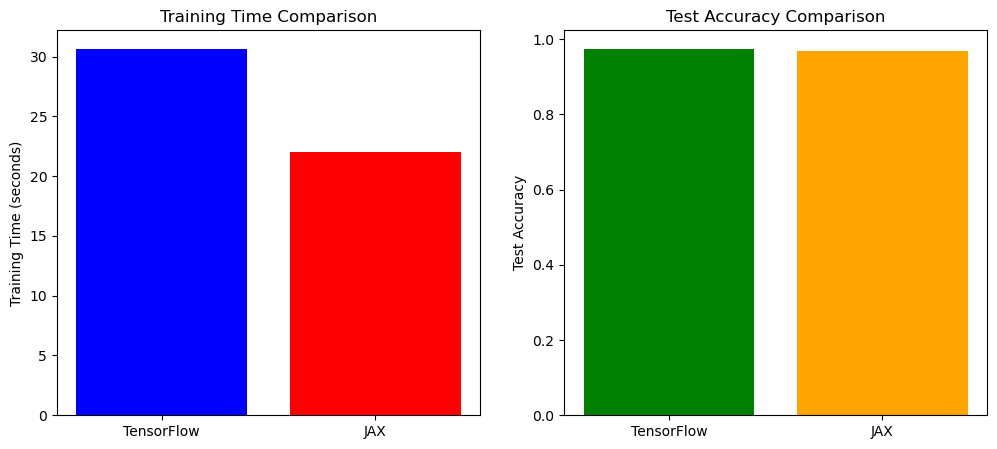

In [17]:
print("Training with TensorFlow:")
tf_time, tf_acc = train_tf_model()

print("\nTraining with JAX:")
jax_time, jax_acc = train_jax_model()

# Plot results
labels = ['TensorFlow', 'JAX']
times = [tf_time, jax_time]
accuracies = [tf_acc, jax_acc]

plt.figure(figsize=(12, 5))

# Training Time Comparison
plt.subplot(1, 2, 1)
plt.bar(labels, times, color=['blue', 'red'])
plt.ylabel('Training Time (seconds)')
plt.title('Training Time Comparison')

# Accuracy Comparison
plt.subplot(1, 2, 2)
plt.bar(labels, accuracies, color=['green', 'orange'])
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy Comparison')

plt.show()

